# Application of Machine Learning on Air Pollution Forecasting
## Problem Background

Air pollution is contamination of the indoor or outdoor environment by any chemical, physical or biological agent that modifies the natural characteristics of the atmosphere.

According to the World Health Organisation ,more than 7 millions of people dead from air pollution per year.[1]

There is suggestive evidence that many diseases are highly associated with air polluction. These diseases include stroke, ischaemic heart disease, chronic obstructive pulmonary disease, lung cancer, pneumonia, and cataract (household air pollution only).  [2]

Moreover, air pollution can cause a large impact to the environment.Air pollution can accelerate the presence of greenhouse effect leading to more extreme weather effect and climate.[3] Hence, mitigrating the effect of air pollution becomes especially curcial.

However,reducing air pollution is a long term effort and requires the cooperations of many countries.[4] In order to mitigrate the issue, countries need to set a suitable target every few years to keep track whether they are on the right path. 

Time seriesforecasting is about predicting a future period of time as accurately as possible, given all factors and information, including historical data and knowledge of any future events that might impact the forecasts.[5]

In our situation, forecasting could be use to predict the future trend. The obtained result can then be used to carried out some caclulation and be set as the target for the country.

In this experiment,we will attempt to use machine learning and evaluate a forecasting model that has the highest performance in predicting the pollution gases over a interval.


## Problem Statement
How can we make use of machine learning to predict pollution gases over time?

## Install Dependencies

In [1]:
!pip install numpy matplotlib pandas seaborn pmdarima scikit-learn==1.0.2 yellowbrick phik statsmodels pyampute xgboost imblearn missingno tqdm mlxtend category-encoders

## Import Libraries

In [2]:
# Utility
from os import path
from os.path import exists # We use this to check if a file exists
from tqdm import tqdm # Use this to track how much time each iter of a for loop takes
import warnings # Statsmodels likes to throw out warnings. Some of them are important, some are not
from statsmodels.tools.sm_exceptions import *
from collections import defaultdict 
from statsmodels.api import load # load serialized models


# Statistical Analysis
## General
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

## Time Series
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

## Model Validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


# Graphical Plots
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set()
plt.rcParams['figure.figsize'] = (13, 8)

## Data Ingestion

The original dataset consist of 4 features.There are 1312 entries in the dataset. By viewing the basic information of the data structure,we observed that


At first glance, we observed that

    - There is invalid data.(ie. Relative humility and gas concentration cannot be negative)
    - Relative humitity and temperature is fixed for everyday
    - Our data is in long format, should pivot it to wide format
    
After convertion to wide format.We derived with a total of 6 features. There are a total of 328 days of record.

In [3]:
df=pd.read_csv('train.csv',usecols=[0,1,2,3,4])
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.set_index("Date", inplace=True)
df

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667
...,...,...,...,...
2017-02-01,5.267708,39.614930,O3,553.180556
2017-02-02,-55.515972,-24.010417,O3,343.500000
2017-02-03,-14.272917,28.563542,O3,334.458333


In [4]:
data=pd.concat([pd.pivot(df, values="Value", columns="Gas"),df[["T", "RH"]].groupby(df.index).mean()],axis=1)
data

,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333,12.020833,54.883334
2016-03-16,995.250000,681.441667,1021.750000,708.025000,9.833333,64.069791
2016-03-17,1025.250000,806.583333,881.375000,867.375000,11.292708,51.107292
2016-03-18,1064.444444,794.258333,794.527778,996.625000,12.866319,51.530903
2016-03-19,1088.741667,755.083333,800.883333,987.341667,16.016667,48.843750
...,...,...,...,...,...,...
2017-02-01,729.422222,562.650000,797.647222,553.180556,5.267708,39.614930
2017-02-02,474.291667,347.480556,508.180556,343.500000,-55.515972,-24.010417
2017-02-03,615.700000,414.475000,819.733333,334.458333,-14.272917,28.563542


## Data Exploration

In [5]:
max(data.index)

Timestamp('2017-02-05 00:00:00')

The frequency of the dates received are concluded to be in daily frequency.This is found out by verifing the number of days in dataset and number of days in range.

In [6]:
(data.index == data.asfreq("D").index).all()

True

### Data Structure

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   HC      328 non-null    float64
 2   NO2     328 non-null    float64
 3   O3      328 non-null    float64
 4   T       328 non-null    float64
 5   RH      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


### Descriptive Statistic
From the descriptive statistic for quantitative data ,we observed that

    - There are invalid data throughout the dataset( ie. negative value in gases and relative humidity 
    - The highest temperature in the region is 33 degree calcius.
    - The relative humidity is high.
    - The average concentraion of CO is the highest. This is not surprising as vehicles tend to release CO.
    - The standard derivative for O3 gas is relatively high.This indicates high variance in O3 gas.
    

In [8]:
data.describe()

,CO,HC,NO2,O3,T,RH
count,328.000000,328.000000,328.000000,328.000000,328.000000,328.000000
mean,840.583477,729.588974,650.087974,780.614931,11.634917,39.873729
std,204.831525,190.472814,193.658229,261.846007,37.084233,43.267370
min,-160.000000,-160.000000,-160.000000,-160.000000,-200.000000,-200.000000
25%,779.191667,662.795833,566.095833,639.850000,12.387760,36.348177
50%,864.141667,753.681944,659.325000,794.893056,18.832292,46.078993
75%,946.431250,847.712500,754.351389,944.608333,25.557118,57.932292
max,1210.566667,1084.083333,1342.950000,1436.233333,32.997917,81.104167


### Invalid Data
In our attempt to find invalid data,we found 22 rows of invalid data. From the invalid data,we observed that
        
        - The chance of all 4 gases,temperature and relative humidility being invalid is relatively high. This can potentially indicates that sensor fails at certain environment resulting all 6 sensor not working or sensor may be in maintainence.

In [9]:
print(str(len(data[(data < 0.00).any(axis=1)])) + " rows of invalid data found")
data[(data < 0.00).any(axis=1)]

22 rows of invalid data found


,CO,HC,NO2,O3,T,RH
Date,,,,,,
2016-04-06,850.991667,687.247222,596.386111,789.052778,-11.426042,19.742014
2016-04-14,-114.133333,-122.766667,-124.466667,-114.958333,-191.164583,-188.839583
2016-05-30,598.225000,569.850000,623.550000,557.075000,-23.920833,-24.786458
2016-05-31,489.027778,530.961111,480.750000,514.877778,-57.951736,-61.500694
2016-06-24,385.402778,326.963889,362.972222,305.705556,-68.069792,-58.296875
2016-06-25,-160.000000,-160.000000,-160.000000,-160.000000,-200.000000,-200.000000
2016-06-26,606.991667,630.991667,560.566667,519.941667,-12.148958,-5.416667
2016-08-14,652.894444,566.805556,486.658333,590.861111,-9.852431,9.186111
2016-08-31,48.866667,14.841667,82.016667,-0.975000,-144.072917,-138.672917


### Missing Data
From our observation ,there seems to be no missing data.

In [11]:
pd.DataFrame(data.isna().sum().sort_values(ascending=False),columns=['Number of missing data'])

,Number of missing data
CO,0
HC,0
NO2,0
O3,0
T,0
RH,0


In [12]:
data[data.isnull().any(axis=1)]

,CO,HC,NO2,O3,T,RH
Date,,,,,,


<AxesSubplot:title={'center':'Number of missing value in features'}>

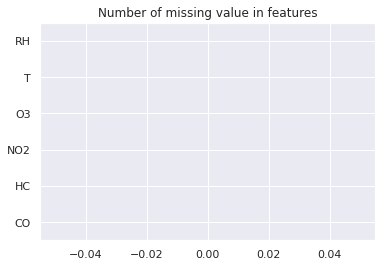

In [13]:
data.isna().sum().sort_values().plot.barh(title='Number of missing value in features')

### Anomaly Detection

Anomaly detection is the findings of rare events or observations which differs significantly from the majority of the data.[6]

In anomaly detection, we adapted the Exponentially Weighted Moving Average with a window of 7.The advantage of it compared to Simple Moving Average is that EWMA gives more weight and significance to recent periodic data.[7]

In this experiment, data above/below 2 standard derivative of the mean will be considered as outlier.

From the figure below ,we observed that many anomalies seems to be common throughout the gases,relative humidity and temperature.

In [14]:
span=7
def outlier_detection(target=None,windows=7,name='My Plot',ax=plt):
    mean = target.ewm(windows).mean()
    std = target.ewm(windows).std()
    std[0] = 0 
    nostd=2


    is_outlier = (target > (mean + nostd*std)) | (target < (mean - nostd*std))
    


    ax.plot(target, c = 'b', label = 'Actual Values')
    ax.plot(mean, c = 'r', label = 'Exponentially Weighted Moving Average')
    ax.plot((mean + nostd*std), 'k--', label = 'Prediction Bounds')
    ax.plot((mean - nostd*std), 'k--')
    ax.set_title(name)
    ax.scatter(target[is_outlier].index, target[is_outlier], c = 'r', marker = 'o', s = 120, label = 'Outliers')
    ax.legend()
    return is_outlier

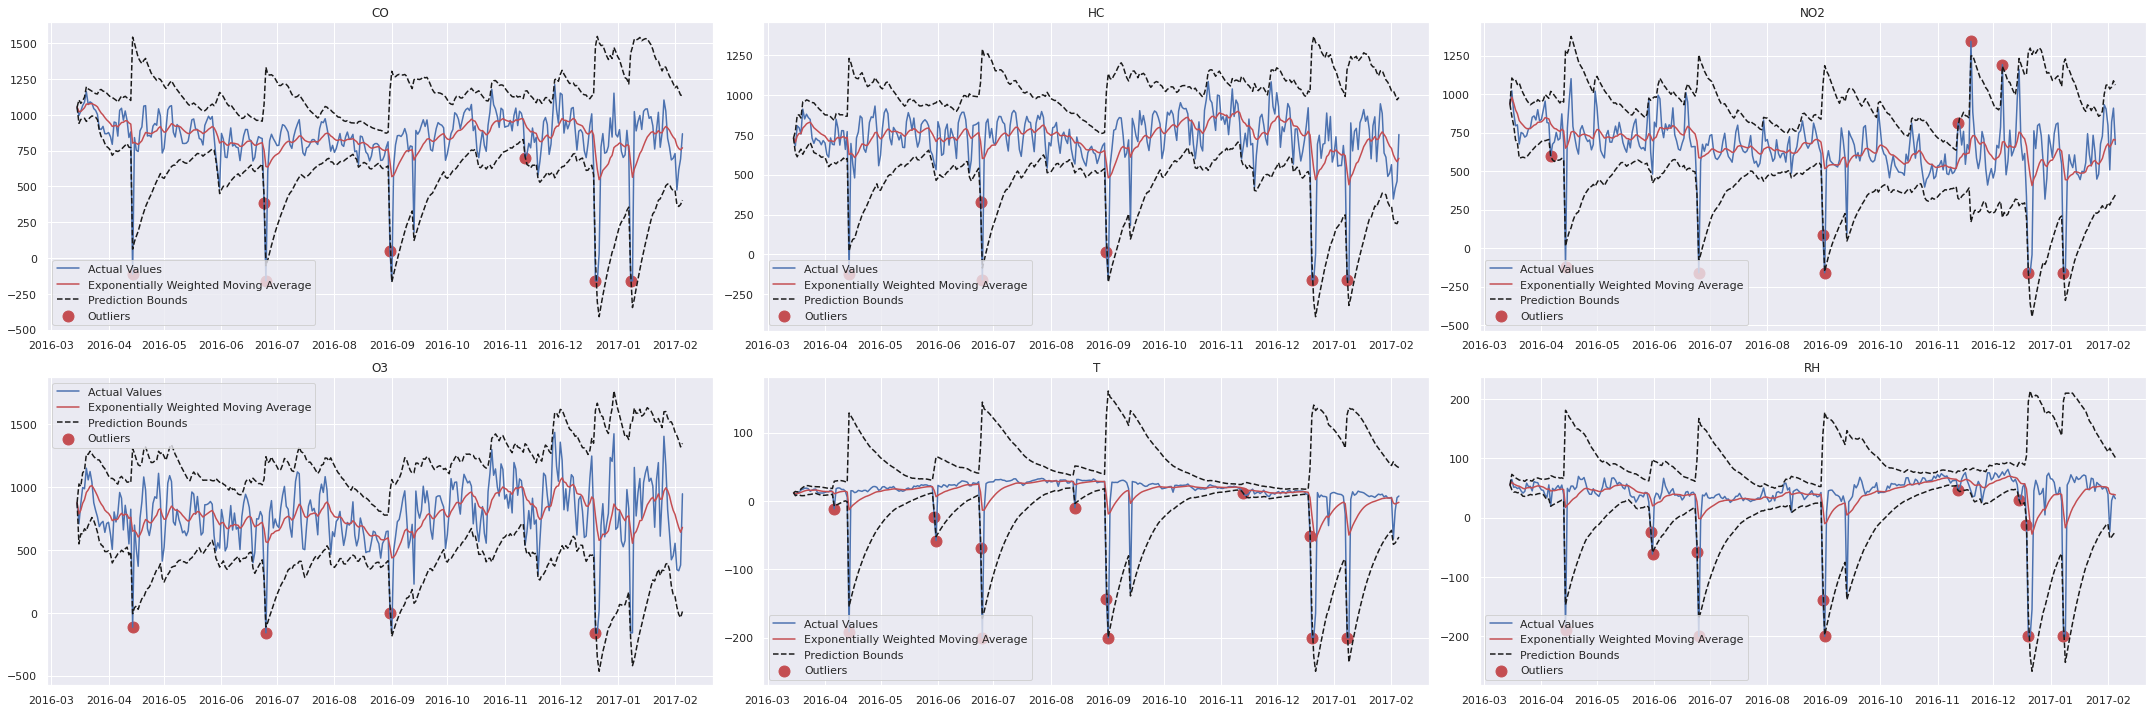

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(30, 10), tight_layout=True)
ax = ax.flatten()
for col,name in enumerate(data.columns):
    outlier_detection(data[name],7,name,ax[col])

### Distribution

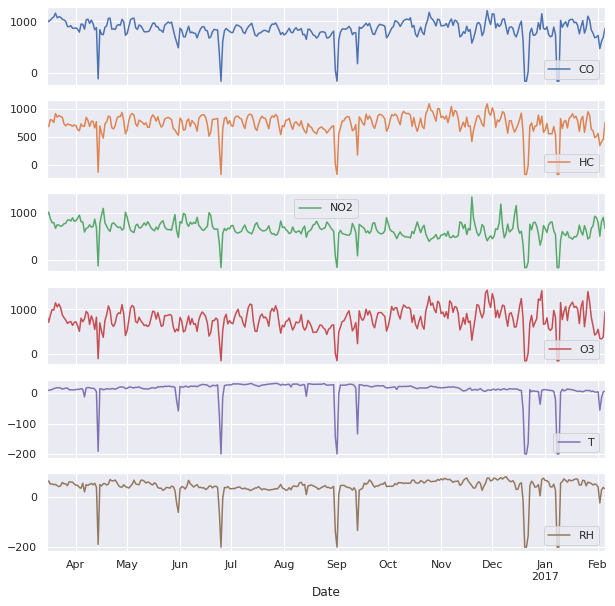

In [16]:
data.plot(subplots=True, figsize=(10, 10))
plt.show()

The distribution for all feature seems to be postively skewed

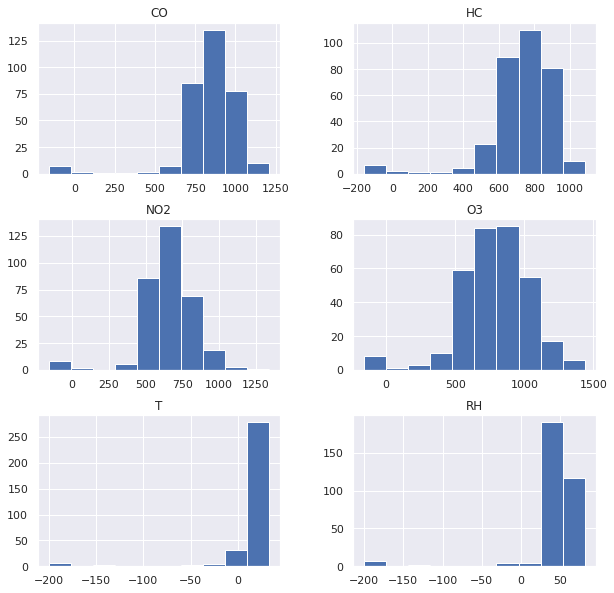

In [17]:
data.hist(figsize=((10,10)))
cdata=data
plt.show()

### Seasonal and Trend decomposition using Loess
Time series can contain a variety of pattern. It is crucial that split the time series into several component to analyse the time series in greater detail. There maybe 3 type of component in the time series: Seasonal component,trend component and remainder component.[8]

There is 2 ways we can decompose our data: Additive($y_t = S_t + T_t + R_t$) and Multiplicative($y_t = S_t * T_t * R_t$).[8] We will use a additive model for this experiment.

In this paper,we will use STL decomposition.The advantage of STL compared to classical decomposition methods is that it is robust to outliers where we discovered previously and allows for the seasonal component to varies.[7]




In [21]:
def strength(stl=None,element='Unknown element',record=pd.DataFrame({'Name':[],'Seasonality':[],'Trend':[]})):
    trend=max(0,1-(stl.resid.var())/(stl.trend+stl.resid).var())
    season=max(0,1-(stl.resid.var())/(stl.seasonal+stl.resid).var())
    print('The trend and seasonality have a strength of '+str(trend)+', '+str(season)+' respectively.')
    record=pd.concat([record,pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]})],ignore_index=True)
    return pd.DataFrame({'Name':[element],'Seasonality':[season],'Trend':[trend]}),record
    

In [22]:
from statsmodels.tsa.seasonal import STL
def STLDecomposition(target,):
    stl = STL(target,robust=True)
    res = stl.fit()
    fig = res.plot()
    return res

The trend and seasonality have a strength of 0.2343178064071222, 0.006152148821640613 respectively.


,Name,Seasonality,Trend
0,CO,0.006152,0.234318


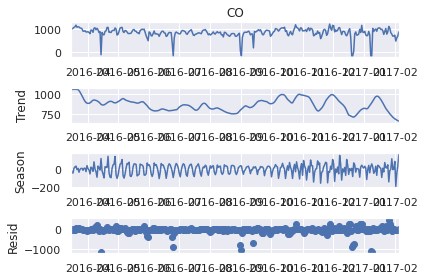

In [23]:
current,record=strength(STLDecomposition(cdata.CO),'CO')
current


From the decomposition above, we found out that the CO gas

                - Have a downward decreasing non-linear trend at the start. Then changing to a increasing upward trend at mid of the year. The trend seems to be more inconsistent near the end of the year.
                - The overall seasonality seems to be weak.
                - The seasonality seems to be inconsistent in overall. There is inconsistency mostly at start and end of the year.
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

The trend and seasonality have a strength of 0.07214286862910746, 0 respectively.


,Name,Seasonality,Trend
0,Temperature,0,0.072143


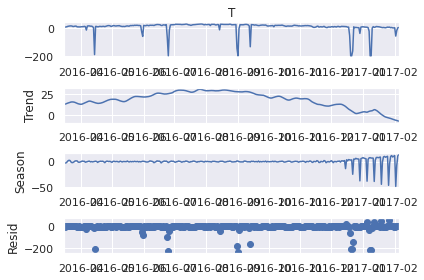

In [24]:
current,record=strength(STLDecomposition(cdata['T']),'Temperature',record)
current


From the decomposition above, we found out that the temperature

                - Have a increasing trend at the start till augest then decreasing downward. It have a non-linear trend.
                - The seasonality is weak and consistent at the start. However, it seems to become inconsistent and strong at the end of the year.
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

The trend and seasonality have a strength of 0.22432705428697508, 0.04864076779543569 respectively.


,Name,Seasonality,Trend
0,NO2,0.048641,0.224327


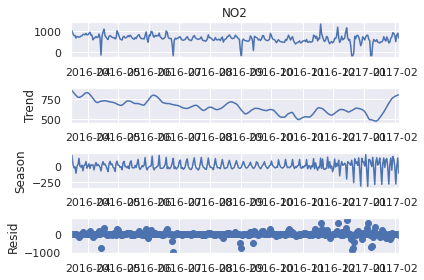

In [25]:
current,record=strength(STLDecomposition(cdata['NO2']),'NO2',record)
current



From the decomposition above, we found out that the NO2 gas

                - Have a downward decreasing non-linear trend at the start. But seems to become a increasing upward trend from mid of the year.
                - The seasonality seems to be inconsistent in overall. There is inconsistency mostly at start and end of the year.
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

The trend and seasonality have a strength of 0.08315474712997395, 0.0004326208435508905 respectively.


,Name,Seasonality,Trend
0,Relative Humidity,0.000433,0.083155


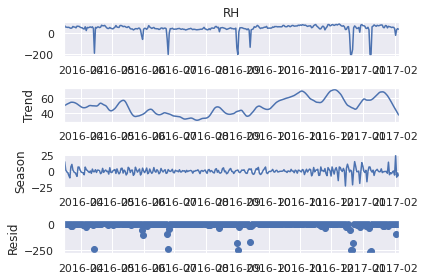

In [26]:
current,record=strength(STLDecomposition(cdata['RH']),'Relative Humidity',record)
current


From the decomposition above, we found out that the relative humidity

                - Have a downward decreasing non-linear trend at the start . At the mid of the year ,it started increasing upward.
                - The seasonality seems to be inconsistent in overall. There is inconsistency mostly at start and end of the year.
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

The trend and seasonality have a strength of 0.29912672414132824, 0.1427559750892914 respectively.


,Name,Seasonality,Trend
0,O3,0.142756,0.299127


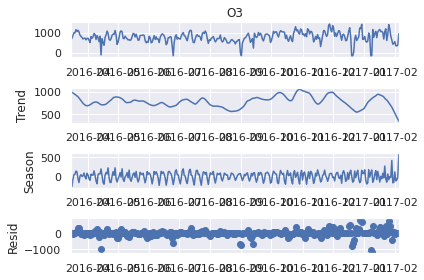

In [27]:

current,record=strength(STLDecomposition(cdata['O3']),'O3',record)
current



From the decomposition above, we found out that the O3 gas

                - has a downward non-linear trend from the start to mid of the year, before changing direction to a upward trend.
                - The seasonality seems to be slightly inconsistent in overall. There is inconsistency mostly at start and end of the year.
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

The trend and seasonality have a strength of 0.24154529359196897, 0.09162923898139386 respectively.


,Name,Seasonality,Trend
0,HC,0.091629,0.241545


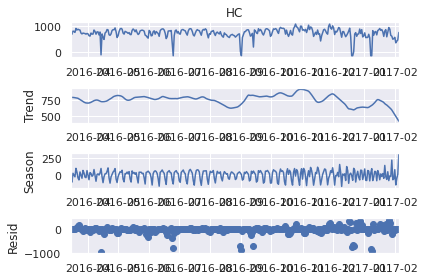

In [28]:

current,record=strength(STLDecomposition(cdata['HC']),'HC',record)
current



From the decomposition above, we found out that the HC gas

                - has a downward non-linear trend from the start to mid of the year, before changing direction to a upward trend.
                - The seasonality seems to be slightly inconsistent in overall. There is inconsistency mostly at start and end of the year.
                - It seems to have weak seasonality
                - The seasonality seems to be weekly based. This could have response to the emission at weekdays compared to weekends.

### Measuring Trend and Seasonality
Aside on knowing the basic information regarding the trend and seasonality, we evaluated the strength of the trend and seasonality. These information is useful in helping us in determinding the parameters of the model and demonstrate vulnerable information such as whether to carry out seasonal differencial and etc.

From the table below, we see that the seasonality and trend for the gases are relatively weak.

Since the strength of the seasonal component for all gases are less than 0.64, no seasonal differencing would be carried out.[7]

In [29]:
record

,Name,Seasonality,Trend
0,CO,0.006152,0.234318
1,Temperature,0.000000,0.072143
2,NO2,0.048641,0.224327
3,Relative Humidity,0.000433,0.083155
4,O3,0.142756,0.299127
5,HC,0.091629,0.241545


### Exogenous variables

The Granger causality test (Granger,1969) is a statistical hypothesis test for determining whether one time series is useful in forecasting another.[9]

In this paper, we adapted the granger causality test to validate that the variables like temperature,relative humidity and month are related in forecasting the gases. 

                                H0 : X does not granger cause Y
                                H1 : X does granger cause Y
                                
From the table below, we observed that the H0 is rejected (p-value<0.05) for O3 and HC for both temperature and relative humidity.This shows that the temperature and relative humidity is useful in predicting O3 and HC. Otherwise, H0 is not rejected for CO and NO2 as the p-value is >a=0.05.This means that the temperature and relative humidity may not be related/useful in predicting CO and NO2.


In [30]:
from statsmodels.tsa.stattools import grangercausalitytests
relate=pd.DataFrame({'Gas':[],'Exog  Variable':[],'p-value':[]})
for feature in ['CO','O3','HC','NO2']:
    for exo in ['T','RH']:
        relate=pd.concat([relate,pd.DataFrame({'Gas':[feature],'Exog  Variable':[exo],'p-value':[grangercausalitytests(data[[feature, exo]], maxlag=7)[7][0]['ssr_ftest'][1]]})])
relate       


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4056  , p=0.0366  , df_denom=324, df_num=1
ssr based chi2 test:   chi2=4.4464  , p=0.0350  , df=1
likelihood ratio test: chi2=4.4164  , p=0.0356  , df=1
parameter F test:         F=4.4056  , p=0.0366  , df_denom=324, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8875  , p=0.0572  , df_denom=321, df_num=2
ssr based chi2 test:   chi2=5.8650  , p=0.0533  , df=2
likelihood ratio test: chi2=5.8129  , p=0.0547  , df=2
parameter F test:         F=2.8875  , p=0.0572  , df_denom=321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0022  , p=0.1136  , df_denom=318, df_num=3
ssr based chi2 test:   chi2=6.1389  , p=0.1050  , df=3
likelihood ratio test: chi2=6.0816  , p=0.1077  , df=3
parameter F test:         F=2.0022  , p=0.1136  , df_denom=318, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0560  , p=0.0864  

,Gas,Exog Variable,p-value
0,CO,T,0.215410
0,CO,RH,0.294795
0,O3,T,0.021336
0,O3,RH,0.042020
0,HC,T,0.021448
0,HC,RH,0.007953
0,NO2,T,0.926382
0,NO2,RH,0.959840


In [31]:
from statsmodels.tsa.stattools import grangercausalitytests
relate=pd.DataFrame({'Gas':[],'Exog  Variable':[],'p-value':[]})
rc=cdata.copy()
rc['Month']=cdata.index.month
for feature in ['CO','O3','HC','NO2']:
        relate=pd.concat([relate,pd.DataFrame({'Gas':[feature],'Exog  Variable':['Month'],'p-value':[grangercausalitytests(rc[[feature, 'Month']], maxlag=7)[7][0]['ssr_ftest'][1]]})])
relate       


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0018  , p=0.9658  , df_denom=324, df_num=1
ssr based chi2 test:   chi2=0.0019  , p=0.9656  , df=1
likelihood ratio test: chi2=0.0019  , p=0.9656  , df=1
parameter F test:         F=0.0018  , p=0.9658  , df_denom=324, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0270  , p=0.9734  , df_denom=321, df_num=2
ssr based chi2 test:   chi2=0.0548  , p=0.9730  , df=2
likelihood ratio test: chi2=0.0548  , p=0.9730  , df=2
parameter F test:         F=0.0270  , p=0.9734  , df_denom=321, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2004  , p=0.8961  , df_denom=318, df_num=3
ssr based chi2 test:   chi2=0.6144  , p=0.8931  , df=3
likelihood ratio test: chi2=0.6138  , p=0.8933  , df=3
parameter F test:         F=0.2004  , p=0.8961  , df_denom=318, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2815  , p=0.8898  

,Gas,Exog Variable,p-value
0,CO,Month,0.906703
0,O3,Month,0.572985
0,HC,Month,0.678654
0,NO2,Month,0.827502


## Modelling and Evaluation
In this paper, we will be experimenting 5 models.The model with the highest performance will be selected as the final model.

Cross validation and the information criteria are the main 2 methodolody in selecting the model.


For cross validation,a 5-Fold time series cross validation was applied.

We used the root mean squared error(RMSE) as our primary metric. RMSE measuress the standard deviation of the prediction error.[10] It tells us how concentrated the data is around the line of best fit.The calculation of RMSE is given below.
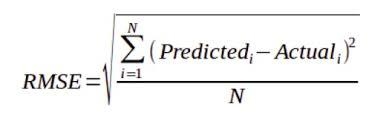

Information metric is a measure of the quality of a statistical model and helps to provide measures of model performance that account for model complexity.[11]

AIC is a metric that is commonly used in researches,it is an estimate of a constant plus the relative distance between the unknown true likelihood function of the data and the fitted likelihood function of the model.[12]

However,Burnham & Anderson (2004) suggested using AICC should be used when sample size is small. [12] 


Therefore,corrected Akaike information criterion(AICC) and Bayesian information criterion(BIC) was used as sub metric in evaluating the model.

** Note: AICC and BIC was only collected from the 5th model in the cross validation.

A baseline model was also implemented to determine the bottom line of all models that can be used to compare against other models and further evaluate the performance of model. In this, paper we will be producing the naive forecast as the baseline.

In [32]:
import warnings
warnings.filterwarnings("ignore")

In [307]:
def EvaluationCV(data,columns,algorithm=ExponentialSmoothing,name='Unknown',n=5,parameter=dict({
    'CO':dict({
    }),
    'NO2':dict({
    }),
    'O3':dict({
    }),
    'HC':dict({
    })
}),exog=None,typeal='ARI',record=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[],'Corrected AIC':[],'BIC':[]})):
    current=pd.DataFrame({"Component":[],'Train RMSE':[],'Test RMSE':[],'Corrected AIC':[],'BIC':[]})
    lasttestrmse=[]
    lasttrainrmse=[]
    lastaicc=[]
    lastbic=[]
    
    if typeal=='Smoothing':
        fig, ax = plt.subplots(2, 2, figsize=(13, 13))
        ax = ax.flatten()
        axcount=0
    if typeal=='Multi':
        testr=[ [0]*n for i in range(len(columns))]
        trainr=[ [0]*n for i in range(len(columns))]
        aicc=0
        bic=0
        count=0
        for train_index, test_index in TimeSeriesSplit(n_splits=n).split(data[columns]):
            model=algorithm(data[columns].iloc[train_index],**(parameter['CO']),exog=data[exog].iloc[train_index,0:2]).fit()
            y_pred=model.predict(min(data.index[test_index]),max(data.index[test_index]),exog=data[exog].iloc[test_index,0:2])
            testrmse=[]
            trainrmse=[]
            for ind,feature in enumerate(y_pred.columns):
                trainr[ind][count]=mean_squared_error(data[feature].iloc[train_index], model.predict(min(data[columns].iloc[train_index].index),max(data[columns].iloc[train_index].index))[feature], squared=False)        
                testr[ind][count]=mean_squared_error(data[feature].iloc[test_index], y_pred[feature], squared=False)

            count=count+1
            if (count==4):
                aicc=model.aicc
                bic=model.bic
        lastaicc='NA'
        lastbic='NA'
        lasttrainrmse='NA'
        lasttestrmse='NA'
        for ind,idr in enumerate(columns):
            current=pd.concat([current,pd.DataFrame({"Component":[name+' on '+idr],'Train RMSE':[sum(trainr[ind])/len(trainr[ind])],'Test RMSE':[sum(testr[ind])/len(testr[ind])],'Corrected AIC':[aicc/len(columns)],'BIC':[bic/len(columns)]})])

   
    if typeal=='ARI' or typeal=='Smoothing':
        for ind,feature in enumerate(columns):
            testrmse=[]
            trainrmse=[]
            instances=[]
            count=0
            for train_index, test_index in TimeSeriesSplit(n_splits=n).split(data[feature]):
                count=count+1
                if exog:

                    model=algorithm(data[feature][train_index],**(parameter[feature]),exog=data[exog].iloc[train_index,0:2]).fit()
                    y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index),exog=data[exog].iloc[test_index,0:2])
                else:
                    model=algorithm(data[feature][train_index],**(parameter[feature])).fit()
                    y_pred=model.predict(min(data[feature][test_index].index),max(data[feature][test_index].index))
                if count==n and typeal=='ARI':
                    model.plot_diagnostics(figsize=((8,5)))
                    lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                    lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
                    lastaicc.append(model.aicc)
                    lastbic.append(model.bic)
                elif count==n:
                    model.resid.plot(ax=ax[axcount])
                    ax[axcount].set_title('Residuel plot for '+feature)
                    axcount=axcount+1
                    lasttestrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                    lasttrainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
                    lastaicc.append(model.aicc)
                    lastbic.append(model.bic)
                instances.append(len(train_index))
                testrmse.append(mean_squared_error(data[feature][test_index], y_pred, squared=False))
                trainrmse.append(mean_squared_error(data[feature][train_index], model.predict(min(data[feature][train_index].index),max(data[feature][train_index].index)), squared=False))
                
            current=pd.concat([current,pd.DataFrame({"Component":[name+' on '+feature],'Train RMSE':[sum(trainrmse)/len(trainrmse)],'Test RMSE':[sum(testrmse)/len(testrmse)],'Corrected AIC':[lastaicc[-1]],'BIC':[lastbic[-1]]})])
    record=pd.concat([record,current])
    lastprediction=pd.DataFrame({'Feature':columns,'Last Train RMSE':lasttrainrmse,'Last Test RMSE':lasttestrmse,'Corrected AIC':lastaicc,'BIC':lastbic})
    return current,record,lastprediction


### Exponential Smoothing

In [308]:
parameter=dict({
    'CO':dict({
        'seasonal':'add',
        'seasonal_periods':7
    }),
    'NO2':dict({
#           'trend':'mul',
        'seasonal':'add',
         'seasonal_periods':7
    }),
    'O3':dict({

        'seasonal':'add',
         'seasonal_periods':7
    }),
    'HC':dict({
#           'trend':'mul',
        'seasonal':'add',
         'seasonal_periods':7
    })
})

,Feature,Last Train RMSE,Last Test RMSE,Corrected AIC,BIC
0,CO,154.85833,341.14995,2782.30348,2813.81400
1,NO2,151.52954,287.24227,2770.39539,2801.90590
2,O3,176.35777,408.99029,2853.54569,2885.05621
3,HC,141.83496,306.85398,2734.16357,2765.67409


,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,Exponential Smoothing on CO,160.04575,201.99180,2782.30348,2813.81400
0,Exponential Smoothing on NO2,152.00947,182.55447,2770.39539,2801.90590
0,Exponential Smoothing on O3,181.81021,270.03746,2853.54569,2885.05621
0,Exponential Smoothing on HC,142.44258,183.38840,2734.16357,2765.67409


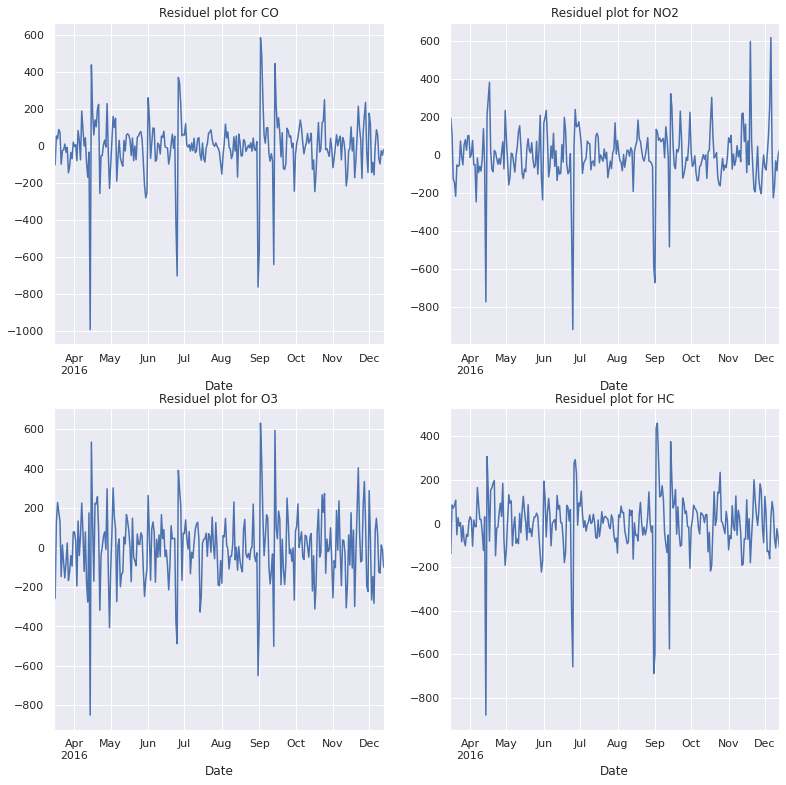

In [309]:
current,record,lastprediction=EvaluationCV(cdata,['CO','NO2','O3','HC'],ExponentialSmoothing,'Exponential Smoothing',5,parameter,typeal='Smoothing')
display(lastprediction)
current

### ARIMA

#### Unit Root Test and Stationary Test
The Kwiatkowski–Phillips–Schmidt–Shin test is a common stationary test carried out by researches in test of trend-stationary.
While the Augmented Dickey Fuller test is used to test for unit root.



KPSS test:
Null Hypothesis: the process is trend-stationary
Alternative Hypothesis: the process has a unit root 


ADF test:
Null Hypothesis: the process has a unit-root ("difference stationary")
Alternative Hypothesis: the process has no unit root. It can mean either that the process is stationary, or trend stationary, depending on which version of the ADF test is used.



In normal situation, the unit root test and stationary test should agree with each other. However, in some cases, they may not agree.

Case 1:Unit root test: you can’t reject 𝐻0; KPSS test: reject 𝐻0. Both imply that series has unit root.

Case 2:Unit root test: Reject 𝐻0. KPSS test: don't reject 𝐻0. Both imply that series is stationary.

Case 3:If we can’t reject both test: data give not enough observations.

Case 4:Reject unit root, reject stationarity: both hypotheses are component hypotheses – heteroskedasticity in a series may make a big difference; if there is structural break it will affect inference.[13]



In our cases, all the gases implies case 2 which mean that the series is stationary.

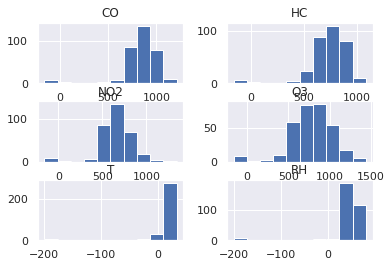

In [36]:
cdata.hist()
plt.show()

In [37]:
def adftest(df, significance_level = 0.05):
    for feature in df.columns:
        print('-----------'+feature+'-------------')
        print(f"Test for Stationarity: {significance_level}\nH0: It is unit root \nH1: It is not unit root")
        test_statistic, pvalue, usedlag,*w, = adfuller(df[feature])
        print(f"p-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Since the p-values of "+str(pvalue)+"is <a=0.05.There is sufficient evidence to reject H0 that the data is unit root.")
        else:
            print("Since the p-values of "+str(pvalue)+"is >a=0.05. There is insufficient evidence to reject H0 that the data is unit root.")
        print('----------------------------------')

In [38]:
def kpsstest(df, significance_level = 0.05):
    for feature in df.columns:
        print('-----------'+feature+'-------------')
        print(f"Test for Stationarity: {significance_level}\nH0: It is trend-stationary \nH1: It  has a unit root")
        test_statistic, pvalue, usedlag,*w, = kpss(df[feature])
        print(f"p-value: {pvalue:.3f}")
        print(f"Used Lag: {usedlag}")
        if pvalue < significance_level:
            print("Since the p-values of "+str(pvalue)+"is <a=0.05.There is sufficient evidence to reject H0 that the data is stationary.")
        else:
            print("Since the p-values of "+str(pvalue)+"is >a=0.05. There is insufficient evidence to reject H0 that the data is stationary.")
        print('----------------------------------')

In [39]:
adftest(cdata)

-----------CO-------------
Test for Stationarity: 0.05
H0: It is unit root 
H1: It is not unit root
p-value: 0.000
Used Lag: 1
Since the p-values of 2.6870035539955553e-16is <a=0.05.There is sufficient evidence to reject H0 that the data is unit root.
----------------------------------
-----------HC-------------
Test for Stationarity: 0.05
H0: It is unit root 
H1: It is not unit root
p-value: 0.000
Used Lag: 1
Since the p-values of 1.2969233046266435e-16is <a=0.05.There is sufficient evidence to reject H0 that the data is unit root.
----------------------------------
-----------NO2-------------
Test for Stationarity: 0.05
H0: It is unit root 
H1: It is not unit root
p-value: 0.000
Used Lag: 1
Since the p-values of 1.3789238914806102e-17is <a=0.05.There is sufficient evidence to reject H0 that the data is unit root.
----------------------------------
-----------O3-------------
Test for Stationarity: 0.05
H0: It is unit root 
H1: It is not unit root
p-value: 0.000
Used Lag: 1
Since the p

In [40]:
kpsstest(cdata)

-----------CO-------------
Test for Stationarity: 0.05
H0: It is trend-stationary 
H1: It  has a unit root
p-value: 0.100
Used Lag: 7
Since the p-values of 0.1is >a=0.05. There is insufficient evidence to reject H0 that the data is stationary.
----------------------------------
-----------HC-------------
Test for Stationarity: 0.05
H0: It is trend-stationary 
H1: It  has a unit root
p-value: 0.100
Used Lag: 7
Since the p-values of 0.1is >a=0.05. There is insufficient evidence to reject H0 that the data is stationary.
----------------------------------
-----------NO2-------------
Test for Stationarity: 0.05
H0: It is trend-stationary 
H1: It  has a unit root
p-value: 0.010
Used Lag: 7
Since the p-values of 0.01is <a=0.05.There is sufficient evidence to reject H0 that the data is stationary.
----------------------------------
-----------O3-------------
Test for Stationarity: 0.05
H0: It is trend-stationary 
H1: It  has a unit root
p-value: 0.100
Used Lag: 7
Since the p-values of 0.1is >a

For the gases, We mostly reject H0 in Unit Root Test and dont reject H0 in Stationary Test.Therefore, we will assume stationary

#### Selecting the Order of the ARIMA Model

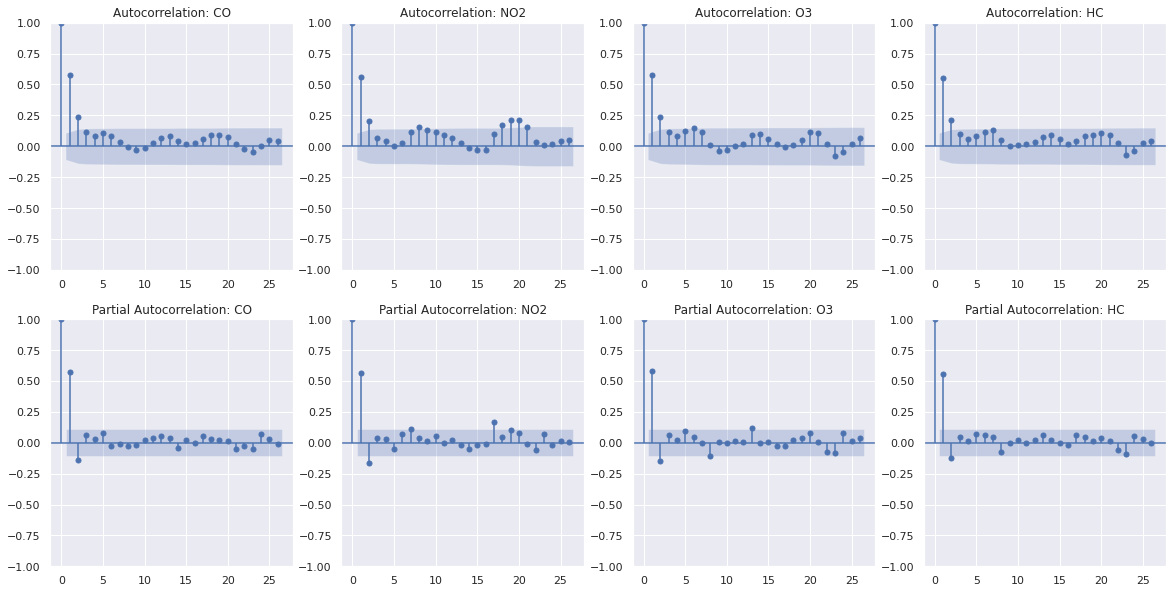

In [41]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j])
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)
    

In [42]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Order':['(1,0,2)','(2,0,2)','(2,0,2)','(1,0,2)']})

,Name,Order
0,CO,"(1,0,2)"
1,NO2,"(2,0,2)"
2,O3,"(2,0,2)"
3,HC,"(1,0,2)"


In [43]:
from pmdarima.arima import auto_arima
def arimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,
                                     exogenous=exogenous,max_order=None
)
    return autoarima_model



In [44]:
current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    arima_model = arimamodel(cdata[feature])
    parameter = arima_model.get_params().get('order')
    now=pd.DataFrame({'Name':[feature],'Order':[parameter]})
    current=pd.concat([current,now])
current

,Name,Order
0,CO,"(0, 0, 3)"
0,NO2,"(1, 0, 3)"
0,O3,"(0, 0, 2)"
0,HC,"(2, 0, 0)"


,Feature,Last Train RMSE,Last Test RMSE,Corrected AIC,BIC
0,CO,69.49550,101.50284,3114.19139,3139.06223
1,NO2,104.94032,154.57842,3341.68995,3370.05157
2,O3,140.23904,251.65767,3499.26377,3520.62793
3,HC,84.98875,122.66472,3226.91124,3251.78208


,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,ARIMA on CO,66.46117,123.25631,3114.19139,3139.06223
0,ARIMA on NO2,88.35335,148.04473,3341.68995,3370.05157
0,ARIMA on O3,131.95594,218.10398,3499.26377,3520.62793
0,ARIMA on HC,75.08477,118.21494,3226.91124,3251.78208


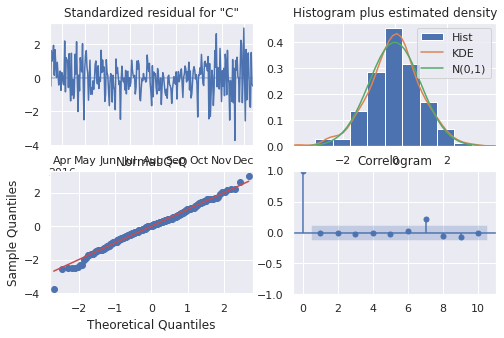

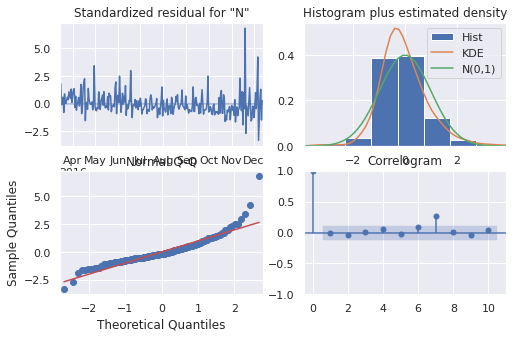

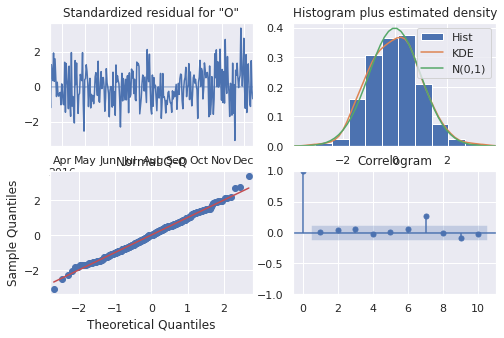

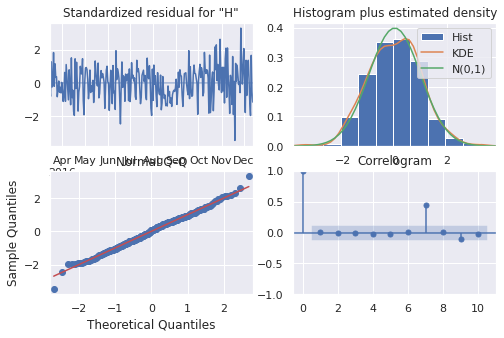

In [310]:
pd.options.display.float_format = '{:.5f}'.format


parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        
    }),
    'O3':dict({

        'order':(0, 0, 2),

    }),
    'HC':dict({
        'order':(1, 0, 2)
    })
})
current,record,lastprediction=EvaluationCV(cdata,['CO','NO2','O3','HC'],ARIMA,'ARIMA',5,parameter,['T','RH'],'ARI',record)
display(lastprediction)
current

In [47]:
def ARIMAManuelGridSearchCV(odata,ft,arimax=True):
    bestresult=300
    finalaccuracy=300
    nick=500
    data=odata[ft].copy()
    for P in np.arange(0,5):
        for Q in np.arange(0,6):
            order = (P,0,Q)
            temp=[]
            count=0
            for train_index, test_index in TimeSeriesSplit(n_splits=5).split(data):
                count=count+1
                model=ARIMA(data[train_index],order=order,exog=odata[['T','RH']].iloc[train_index,0:2]).fit()
                y_pred=model.predict(min(data[test_index].index),max(data[test_index].index),exog=odata[['T','RH']].iloc[test_index,0:2])
                temp.append(mean_squared_error(data[test_index], y_pred, squared=False))

            if (temp[4])<finalaccuracy:
                bestresult=(P,0,Q)
                finalaccuracy=temp[4]
                nick=sum(temp)/len(temp)
    return bestresult,finalaccuracy,nick
bestresult,finalaccuracy,nick=HanGridSearchCV(cdata,'NO2')
finalaccuracy


KeyboardInterrupt



### SARIMAX

#### Seasonal Order

In [48]:
slag = [i*7 for i in range(13)]
slag

[0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]

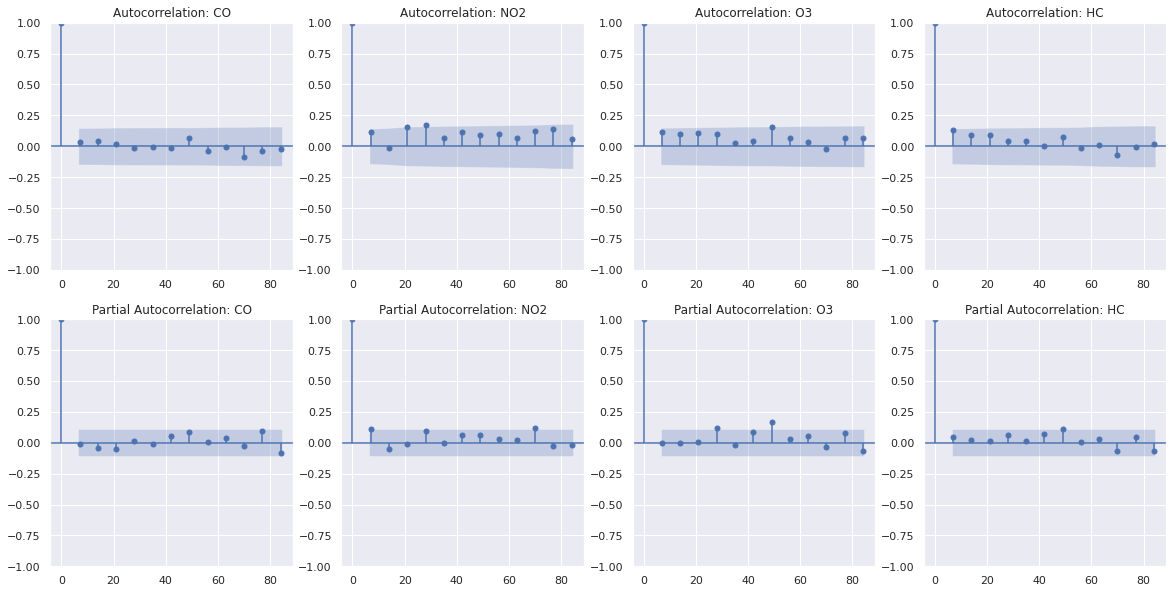

In [49]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i, plot in enumerate([plot_acf, plot_pacf],0):
    for j, gas in enumerate(['CO','NO2','O3','HC'], 0):
        
        plot(cdata[gas], ax=ax[i,j], lags=slag)
        ax[i,j].set_title(ax[i,j].title._text + ': ' + gas)

In [50]:
pd.DataFrame({'Name':['CO','NO2','O3','HC'],'Seasonal Order':['(0,0,0,7)','(0,0,0,7)','(0,0,0,7)','(0,0,0,7)']})

,Name,Seasonal Order
0,CO,"(0,0,0,7)"
1,NO2,"(0,0,0,7)"
2,O3,"(0,0,0,7)"
3,HC,"(0,0,0,7)"


In [51]:
from pmdarima.arima import auto_arima
def sarimamodel(timeseriesarray, exogenous=cdata[['T','RH']]):
    autoarima_model = auto_arima(timeseriesarray, 
                              start_p=0, # auto-regressive (AR)
                              start_q=0, # moving average
                              test="adf", # ADF Augmented Dickey-Fuller test.
                            max_d=4, max_p=4,max_q=4,stationary=True,max_P=7,max_Q=7,start_P=0,start_Q=0,
                                     exogenous=exogenous,max_order=20,seasonal=True,m=7,n_jobs=-1
)
    return autoarima_model

current=pd.DataFrame({'Name':[],'Order':[]})
for feature in ['CO','NO2','O3','HC']:
    sarima_model = sarimamodel(cdata[feature])
    print( sarima_model.summary())
    parameter = sarima_model.get_params()

    now=pd.DataFrame({'Name':[feature],'Order':[str(parameter['order'])+str(parameter['seasonal_order'])]})
    current=pd.concat([current,now])
current

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  328
Model:             SARIMAX(1, 0, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -1862.414
Date:                                Wed, 13 Jul 2022   AIC                           3740.827
Time:                                        10:20:13   BIC                           3771.172
Sample:                                    03-15-2016   HQIC                          3752.934
                                         - 02-05-2017                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     36.7663     23.564      1.560      0.119      -9.418      82.951
T  

,Name,Order
0,CO,"(1, 0, 0)(1, 0, 2, 7)"
0,NO2,"(1, 0, 0)(1, 0, 1, 7)"
0,O3,"(2, 0, 2)(1, 0, 1, 7)"
0,HC,"(1, 0, 0)(2, 0, 1, 7)"


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.81208D+00    |proj g|=  6.78548D-02

At iterate    5    f=  6.75112D+00    |proj g|=  1.50921D-02

At iterate   10    f=  6.57804D+00    |proj g|=  5.09885D-02

At iterate   15    f=  6.40548D+00    |proj g|=  8.58225D-03

At iterate   20    f=  6.38887D+00    |proj g|=  2.40577D-02

At iterate   25    f=  6.31790D+00    |proj g|=  4.39932D-02

At iterate   30    f=  5.90407D+00    |proj g|=  9.44066D-02

At iterate   35    f=  5.80436D+00    |proj g|=  1.69643D-02

At iterate   40    f=  5.80002D+00    |proj g|=  3.36237D-03

At iterate   45    f=  5.79915D+00    |proj g|=  1.13514D-03

At iterate   50    f=  5.79907D+00    |proj g|=  2.92141D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.72088D+00    |proj g|=  2.27426D-02

At iterate   10    f=  6.45394D+00    |proj g|=  6.28823D-02

At iterate   15    f=  6.43507D+00    |proj g|=  3.94699D-03

At iterate   20    f=  6.41113D+00    |proj g|=  3.51732D-02

At iterate   25    f=  5.83732D+00    |proj g|=  1.65621D-01

At iterate   30    f=  5.68291D+00    |proj g|=  2.55763D-03

At iterate   35    f=  5.68285D+00    |proj g|=  1.39981D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     52      1     0     0   1.400D-05   5.683D+00
  F =   5.6828456178782814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  6.67750D+00    |proj g|=  4.86257D-02

At iterate   15    f=  6.58317D+00    |proj g|=  2.97052D-02

At iterate   20    f=  6.54341D+00    |proj g|=  1.07295D-02

At iterate   25    f=  6.20606D+00    |proj g|=  4.52934D-01

At iterate   30    f=  5.72519D+00    |proj g|=  7.53474D-02

At iterate   35    f=  5.71712D+00    |proj g|=  2.60106D-04
  ys=-1.024E-01  -gs= 8.047E-04 BFGS update SKIPPED

At iterate   40    f=  5.65490D+00    |proj g|=  8.17967D-02

At iterate   45    f=  5.57442D+00    |proj g|=  3.75485D-03

At iterate   50    f=  5.57396D+00    |proj g|=  1.75379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.



At iterate   20    f=  6.22725D+00    |proj g|=  1.30910D-01

At iterate   25    f=  5.75874D+00    |proj g|=  1.98995D-01

At iterate   30    f=  5.68750D+00    |proj g|=  3.69126D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     50      1     0     0   1.119D-05   5.688D+00
  F =   5.6875013477926659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79036D+00    |proj g|=  1.16816D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  6.32699D+00    |proj g|=  7.05542D-03

At iterate   20    f=  6.22308D+00    |proj g|=  7.37412D-02

At iterate   25    f=  5.76556D+00    |proj g|=  3.58501D-02

At iterate   30    f=  5.76357D+00    |proj g|=  2.95961D-05

At iterate   35    f=  5.76356D+00    |proj g|=  5.07630D-04

At iterate   40    f=  5.76318D+00    |proj g|=  9.82454D-03

At iterate   45    f=  5.75297D+00    |proj g|=  1.35137D-02

At iterate   50    f=  5.75205D+00    |proj g|=  5.76496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   5.765D-04   5.752D+00
  F =   5.75204698684

 This problem is unconstrained.



At iterate    5    f=  6.63173D+00    |proj g|=  1.01647D-02

At iterate   10    f=  6.59976D+00    |proj g|=  2.96640D-02

At iterate   15    f=  6.42155D+00    |proj g|=  3.15902D-02

At iterate   20    f=  6.39425D+00    |proj g|=  1.17969D-02

At iterate   25    f=  6.28309D+00    |proj g|=  1.36182D-01

At iterate   30    f=  6.20118D+00    |proj g|=  1.48147D-02

At iterate   35    f=  6.19981D+00    |proj g|=  2.33913D-03

At iterate   40    f=  6.19959D+00    |proj g|=  5.91805D-04

At iterate   45    f=  6.19950D+00    |proj g|=  1.31813D-03
  ys=-2.549E-02  -gs= 2.132E-04 BFGS update SKIPPED

At iterate   50    f=  6.19301D+00    |proj g|=  1.10294D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   45    f=  5.93450D+00    |proj g|=  1.05862D-02

At iterate   50    f=  5.93238D+00    |proj g|=  9.55616D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   9.556D-04   5.932D+00
  F =   5.9323846378696130     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46704D+00    |proj g|=  1.58132D+00

At iterate    5    f=  6.75573D+00    |proj g|=  7.65996D-02

At iter

 This problem is unconstrained.



At iterate   35    f=  6.01971D+00    |proj g|=  1.39253D-01

At iterate   40    f=  5.98160D+00    |proj g|=  9.71650D-03
  ys=-9.642E-02  -gs= 1.476E-02 BFGS update SKIPPED

At iterate   45    f=  5.84164D+00    |proj g|=  1.99027D-02

At iterate   50    f=  5.84051D+00    |proj g|=  1.77379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     1     0   1.774D-03   5.841D+00
  F =   5.8405069316512552     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0   

 This problem is unconstrained.



At iterate   10    f=  6.33505D+00    |proj g|=  2.17384D-02

At iterate   15    f=  6.27339D+00    |proj g|=  2.84118D-02

At iterate   20    f=  5.98654D+00    |proj g|=  8.93846D-02

At iterate   25    f=  5.86528D+00    |proj g|=  9.62437D-03

At iterate   30    f=  5.84559D+00    |proj g|=  5.65600D-02

At iterate   35    f=  5.81013D+00    |proj g|=  2.07859D-02

At iterate   40    f=  5.80754D+00    |proj g|=  1.02575D-02

At iterate   45    f=  5.80419D+00    |proj g|=  6.14640D-03

At iterate   50    f=  5.80371D+00    |proj g|=  3.45405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62   

 This problem is unconstrained.



At iterate   20    f=  6.32789D+00    |proj g|=  8.86384D-03

At iterate   25    f=  6.31814D+00    |proj g|=  1.65869D-02

At iterate   30    f=  6.10852D+00    |proj g|=  2.08898D-01

At iterate   35    f=  6.07210D+00    |proj g|=  8.06450D-04

At iterate   40    f=  6.07178D+00    |proj g|=  1.18411D-02

At iterate   45    f=  6.06588D+00    |proj g|=  2.54273D-02

At iterate   50    f=  6.06216D+00    |proj g|=  2.38736D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   2.387D-03   6.062D+00
  F =   6.0621585877961541     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  6.68568D+00    |proj g|=  6.53204D-02

At iterate   20    f=  6.63169D+00    |proj g|=  6.90999D-03

At iterate   25    f=  6.62313D+00    |proj g|=  7.32008D-03

At iterate   30    f=  6.61798D+00    |proj g|=  9.75460D-03

At iterate   35    f=  6.46920D+00    |proj g|=  1.69875D-02

At iterate   40    f=  6.46437D+00    |proj g|=  6.09937D-04

At iterate   45    f=  6.46290D+00    |proj g|=  9.42050D-03

At iterate   50    f=  6.46187D+00    |proj g|=  5.64661D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     60      1     0     0   5.647D-04   6.462D+00
  F =   6.46186812029

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74615D+00    |proj g|=  1.97179D+00

At iterate    5    f=  6.79035D+00    |proj g|=  9.70621D-02

At iterate   10    f=  6.76914D+00    |proj g|=  2.82312D-02

At iterate   15    f=  6.59950D+00    |proj g|=  1.73607D-02

At iterate   20    f=  6.58377D+00    |proj g|=  8.99382D-03

At iterate   25    f=  6.57675D+00    |proj g|=  4.17383D-03



 This problem is unconstrained.


At iterate   30    f=  6.53220D+00    |proj g|=  4.53499D-02

At iterate   35    f=  6.51065D+00    |proj g|=  1.57493D-02

At iterate   40    f=  6.37586D+00    |proj g|=  1.34220D-01

At iterate   45    f=  6.28265D+00    |proj g|=  2.61821D-03

At iterate   50    f=  6.27955D+00    |proj g|=  4.94499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   4.945D-03   6.280D+00
  F =   6.2795462370266151     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10


 This problem is unconstrained.



At iterate   10    f=  6.73580D+00    |proj g|=  1.41516D-02

At iterate   15    f=  6.61465D+00    |proj g|=  6.51665D-02

At iterate   20    f=  6.58358D+00    |proj g|=  3.09766D-03

At iterate   25    f=  6.56996D+00    |proj g|=  3.50169D-02

At iterate   30    f=  6.49160D+00    |proj g|=  1.10959D-02

At iterate   35    f=  6.45553D+00    |proj g|=  5.97969D-02

At iterate   40    f=  6.38675D+00    |proj g|=  8.64898D-03

At iterate   45    f=  6.38529D+00    |proj g|=  2.53996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     62      1     0     0   3.654D-05   6.385D+00
  F =   6.38527858065

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.74706D+00    |proj g|=  1.60736D-02

At iterate   10    f=  6.64643D+00    |proj g|=  2.14577D-01

At iterate   15    f=  6.49135D+00    |proj g|=  1.59991D-02

At iterate   20    f=  6.48644D+00    |proj g|=  7.79252D-03

At iterate   25    f=  6.22692D+00    |proj g|=  9.44977D-02

At iterate   30    f=  5.89027D+00    |proj g|=  2.17313D-02

At iterate   35    f=  5.88340D+00    |proj g|=  1.90729D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     50      1     0     0   1.010D-05   5.883D+00
  F =   5.8833950588238242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  6.10698D+00    |proj g|=  3.04892D-01

At iterate   25    f=  5.80556D+00    |proj g|=  1.06739D-02

At iterate   30    f=  5.80494D+00    |proj g|=  2.33210D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     47      1     0     0   9.583D-06   5.805D+00
  F =   5.8049357396338275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.89871D+00    |proj g|=  1.86211D-01


 This problem is unconstrained.



At iterate    5    f=  6.64239D+00    |proj g|=  1.25658D-02

At iterate   10    f=  6.55595D+00    |proj g|=  1.45141D-01

At iterate   15    f=  6.44376D+00    |proj g|=  7.60739D-03

At iterate   20    f=  6.42950D+00    |proj g|=  2.82579D-02

At iterate   25    f=  6.06957D+00    |proj g|=  2.92428D-01

At iterate   30    f=  5.77842D+00    |proj g|=  1.02046D-02

At iterate   35    f=  5.76814D+00    |proj g|=  2.11869D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     49      1     0     0   2.891D-05   5.768D+00
  F =   5.7681397112512718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  6.53605D+00    |proj g|=  9.06603D-03

At iterate   10    f=  6.37850D+00    |proj g|=  3.93783D-03

At iterate   15    f=  6.36455D+00    |proj g|=  3.89645D-02

At iterate   20    f=  6.07732D+00    |proj g|=  1.62618D-01

At iterate   25    f=  5.98916D+00    |proj g|=  1.44905D-02

At iterate   30    f=  5.91646D+00    |proj g|=  1.26582D-01

At iterate   35    f=  5.89022D+00    |proj g|=  2.32610D-03

At iterate   40    f=  5.89013D+00    |proj g|=  5.56471D-04

At iterate   45    f=  5.88975D+00    |proj g|=  1.21582D-02

At iterate   50    f=  5.88928D+00    |proj g|=  2.47176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,Feature,Last Train RMSE,Last Test RMSE,Corrected AIC,BIC
0,CO,89.86304,101.19735,3164.43636,3185.80052
1,NO2,114.81389,165.86569,3336.48396,3361.35480
2,O3,150.88806,257.89221,3513.55371,3538.42456
3,HC,90.03614,133.42299,3241.74595,3266.61679


,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,SARIMAX on CO,106.65033,106.52771,3164.43636,3185.80052
0,SARIMAX on NO2,125.30030,167.80547,3336.48396,3361.35480
0,SARIMAX on O3,162.31195,241.41474,3513.55371,3538.42456
0,SARIMAX on HC,95.45927,117.31122,3241.74595,3266.61679


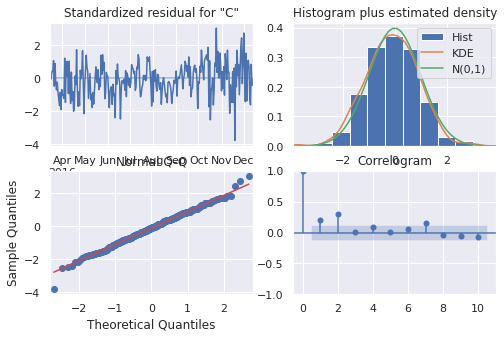

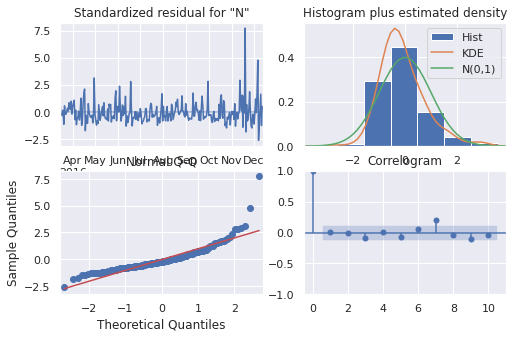

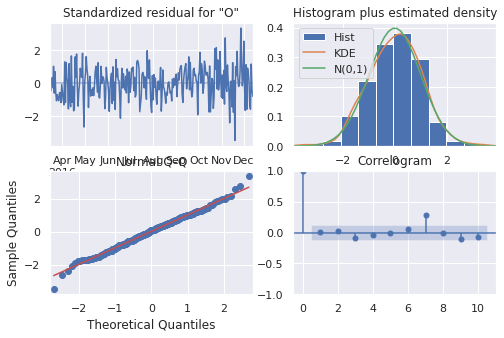

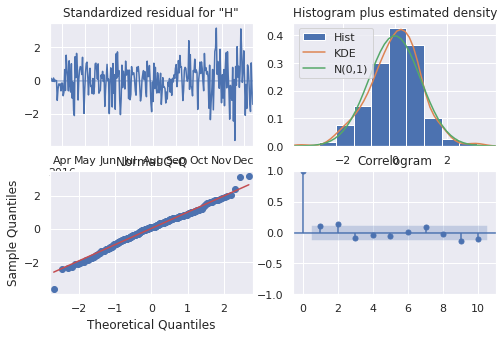

In [311]:


parameter=dict({
    'CO':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse'
    }),
    'NO2':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse',
#            'trend':'ct'
    }),
    'O3':dict({
        'order':(2, 0, 2),
        'seasonal_order':(0, 0, 0, 7),
        'initialization':'approximate_diffuse',

    }),
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7),
        'initialization':'approximate_diffuse',
#         'trend':'ct'
    })
})






current,record,lastprediction=EvaluationCV(cdata,['CO','NO2','O3','HC'],SARIMAX,'SARIMAX',5,parameter,['T','RH'],'ARI',record)
display(lastprediction)
current

In [ ]:
def SarimaxGridSearchCV(odata,col,arimax=True):
    re=[]
    fa=[]
    avgaccuracy=[]
    seaor=[]
    for i in col:
        
        bestresult=300
        finalaccuracy=300
        seas=500
        avgacc=500
        data=odata[i].copy()
        for p in np.arange(0,4):
            for q in np.arange(0,4):
                for P in np.arange(0,4):
                    for Q in np.arange(0,4):
                        order=(p,0,q)
                        seaorder = (P,0,Q,7)
                        temp=[]
                        count=0
                        for train_index, test_index in TimeSeriesSplit(n_splits=5).split(data):
                            count=count+1
                            model=SARIMAX(data[train_index],order=order,seasonal_order=seaorder,initialization='approximate_diffuse',exog=odata[['T','RH']].iloc[train_index,0:2]).fit(disp=0)
                            y_pred=model.predict(min(data[test_index].index),max(data[test_index].index),exog=odata[['T','RH']].iloc[test_index,0:2])
                            temp.append(mean_squared_error(data[test_index], y_pred, squared=False))

                        if (temp[4])<finalaccuracy:
                            bestresult=(p,0,q)
                            seas=(P,0,Q,7)
                            seas=str(seas)
                            bestresult=str(bestresult)
                            finalaccuracy=temp[4]
                            avgacc=sum(temp)/len(temp)
        re.append(bestresult)
        fa.append(finalaccuracy)
        avgaccuracy.append(avgacc)
        seaor.append(seas)
    return re,fa,avgaccuracy,seaor
bestresult,finalaccuracy,avgaccuracy,seaorder=SarimaxGridSearchCV(cdata,['CO','NO2','O3','HC'])


### Dynamic Factor

In [312]:


parameter=dict({
    'CO':dict({
       'k_factors':1,
        'factor_order':2,'error_order': 2
    }),
    'NO2':dict({
       'k_factors':1,
        'factor_order':2,'error_order': 2
    }),
    'O3':dict({
       'k_factors':1,
        'factor_order':2,'error_order': 2

    }),
    'HC':dict({
       'k_factors':1,
        'factor_order':2,'error_order': 2
    })
})

current,record,last=EvaluationCV(cdata,['CO','NO2','O3','HC'],sm.tsa.DynamicFactor,'Dynamic Factor',5,parameter,['T','RH'],'Multi',record)
current

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76886D+01    |proj g|=  4.84578D-02


 This problem is unconstrained.



At iterate    5    f=  2.76652D+01    |proj g|=  6.37488D-03

At iterate   10    f=  2.76527D+01    |proj g|=  2.38455D-02

At iterate   15    f=  2.74993D+01    |proj g|=  8.60857D-02

At iterate   20    f=  2.74299D+01    |proj g|=  1.37669D-02

At iterate   25    f=  2.73807D+01    |proj g|=  2.00187D-02

At iterate   30    f=  2.70443D+01    |proj g|=  1.02975D-01

At iterate   35    f=  2.67727D+01    |proj g|=  1.24040D-01

At iterate   40    f=  2.59985D+01    |proj g|=  2.16683D-01

At iterate   45    f=  2.58341D+01    |proj g|=  5.86511D-02

At iterate   50    f=  2.58031D+01    |proj g|=  3.71129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.82975D+01    |proj g|=  6.68541D-03

At iterate   10    f=  2.82792D+01    |proj g|=  2.32149D-02

At iterate   15    f=  2.82000D+01    |proj g|=  3.75400D-02

At iterate   20    f=  2.81817D+01    |proj g|=  5.88521D-03

At iterate   25    f=  2.81521D+01    |proj g|=  1.30634D-02

At iterate   30    f=  2.73718D+01    |proj g|=  1.68658D-01

At iterate   35    f=  2.72113D+01    |proj g|=  2.70094D-02

At iterate   40    f=  2.70040D+01    |proj g|=  3.79495D-02

At iterate   45    f=  2.68751D+01    |proj g|=  5.60889D-02

At iterate   50    f=  2.68214D+01    |proj g|=  4.54960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.87718D+01    |proj g|=  6.54855D-03

At iterate   10    f=  2.87346D+01    |proj g|=  4.59479D-02

At iterate   15    f=  2.86647D+01    |proj g|=  3.13162D-03

At iterate   20    f=  2.86367D+01    |proj g|=  3.41351D-02

At iterate   25    f=  2.83496D+01    |proj g|=  5.49517D-02

At iterate   30    f=  2.82124D+01    |proj g|=  7.69922D-02

At iterate   35    f=  2.80251D+01    |proj g|=  4.70642D-02

At iterate   40    f=  2.76599D+01    |proj g|=  1.34104D-01

At iterate   45    f=  2.75124D+01    |proj g|=  2.16080D-02

At iterate   50    f=  2.74581D+01    |proj g|=  2.76158D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.86634D+01    |proj g|=  7.62737D-03

At iterate   10    f=  2.86339D+01    |proj g|=  1.43549D-02

At iterate   15    f=  2.85564D+01    |proj g|=  8.04535D-03

At iterate   20    f=  2.85448D+01    |proj g|=  1.05557D-02

At iterate   25    f=  2.84160D+01    |proj g|=  6.65341D-02

At iterate   30    f=  2.81083D+01    |proj g|=  5.14039D-02

At iterate   35    f=  2.73452D+01    |proj g|=  2.05010D-01

At iterate   40    f=  2.71709D+01    |proj g|=  2.32473D-02

At iterate   45    f=  2.70631D+01    |proj g|=  1.56007D-01

At iterate   50    f=  2.69761D+01    |proj g|=  2.59377D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.86928D+01    |proj g|=  1.04036D-02

At iterate   10    f=  2.86142D+01    |proj g|=  2.33922D-02

At iterate   15    f=  2.85419D+01    |proj g|=  5.37579D-03

At iterate   20    f=  2.85229D+01    |proj g|=  1.17486D-02

At iterate   25    f=  2.84349D+01    |proj g|=  1.88881D-02

At iterate   30    f=  2.80081D+01    |proj g|=  3.48354D-02

At iterate   35    f=  2.74451D+01    |proj g|=  1.33699D-01

At iterate   40    f=  2.73398D+01    |proj g|=  1.94529D-02

At iterate   45    f=  2.71152D+01    |proj g|=  3.94693D-02

At iterate   50    f=  2.66933D+01    |proj g|=  5.42104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,Dynamic Factor on CO,587.71864,951.32542,2982.18470,3002.42463
0,Dynamic Factor on NO2,237.36752,245.96620,2982.18470,3002.42463
0,Dynamic Factor on O3,705.57671,1184.26896,2982.18470,3002.42463
0,Dynamic Factor on HC,523.35934,861.50733,2982.18470,3002.42463


### VARIMAX

In [313]:


parameter=dict({
    'CO':dict({
       'order':(0,3),
    }),
    'NO2':dict({
      'order':(0,3),
    }),
    'O3':dict({
      'order':(0,3),

    }),
    'HC':dict({
      'order':(0,3),
    })
})

current,record,last=EvaluationCV(cdata,['CO','NO2','O3','HC'],VARMAX,'VARIMAX',5,parameter,['T','RH'],'Multi',record)
current

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           70     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59259D+01    |proj g|=  1.08225D+01


 This problem is unconstrained.



At iterate    5    f=  2.17024D+01    |proj g|=  1.33351D+00

At iterate   10    f=  2.13478D+01    |proj g|=  5.44568D-01

At iterate   15    f=  2.12229D+01    |proj g|=  4.06180D-01

At iterate   20    f=  2.11369D+01    |proj g|=  2.68450D-01

At iterate   25    f=  2.10787D+01    |proj g|=  2.05519D-01

At iterate   30    f=  2.10180D+01    |proj g|=  3.85065D-01

At iterate   35    f=  2.09841D+01    |proj g|=  2.01747D-01

At iterate   40    f=  2.09436D+01    |proj g|=  2.01681D-01

At iterate   45    f=  2.09176D+01    |proj g|=  1.58584D-01

At iterate   50    f=  2.08781D+01    |proj g|=  1.98260D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.13420D+01    |proj g|=  2.53053D-01

At iterate   10    f=  2.12015D+01    |proj g|=  4.15607D-01

At iterate   15    f=  2.11561D+01    |proj g|=  4.19218D-01

At iterate   20    f=  2.10850D+01    |proj g|=  3.35780D-01

At iterate   25    f=  2.10554D+01    |proj g|=  1.29376D-01

At iterate   30    f=  2.10213D+01    |proj g|=  2.95887D-01

At iterate   35    f=  2.09991D+01    |proj g|=  9.74210D-02

At iterate   40    f=  2.09813D+01    |proj g|=  9.73156D-02

At iterate   45    f=  2.09651D+01    |proj g|=  2.29704D-01

At iterate   50    f=  2.09498D+01    |proj g|=  1.65691D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.17452D+01    |proj g|=  6.32807D-01

At iterate   10    f=  2.15875D+01    |proj g|=  3.72421D-01

At iterate   15    f=  2.14619D+01    |proj g|=  5.22179D-01

At iterate   20    f=  2.14009D+01    |proj g|=  3.08968D-01

At iterate   25    f=  2.13447D+01    |proj g|=  2.89699D-01

At iterate   30    f=  2.13034D+01    |proj g|=  2.24760D-01

At iterate   35    f=  2.12692D+01    |proj g|=  2.41116D-01

At iterate   40    f=  2.12383D+01    |proj g|=  2.02054D-01

At iterate   45    f=  2.12188D+01    |proj g|=  7.37638D-02

At iterate   50    f=  2.12069D+01    |proj g|=  1.36199D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.18510D+01    |proj g|=  7.61569D-01

At iterate   10    f=  2.15756D+01    |proj g|=  8.70385D-01

At iterate   15    f=  2.14569D+01    |proj g|=  2.34106D-01

At iterate   20    f=  2.13645D+01    |proj g|=  3.11482D-01

At iterate   25    f=  2.13202D+01    |proj g|=  1.90285D-01

At iterate   30    f=  2.12908D+01    |proj g|=  1.79715D-01

At iterate   35    f=  2.12607D+01    |proj g|=  2.58592D-01

At iterate   40    f=  2.12331D+01    |proj g|=  2.49715D-01

At iterate   45    f=  2.12162D+01    |proj g|=  3.35070D-01

At iterate   50    f=  2.12018D+01    |proj g|=  3.71171D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  2.23921D+01    |proj g|=  1.03936D+00

At iterate   10    f=  2.20073D+01    |proj g|=  5.61787D-01

At iterate   15    f=  2.18906D+01    |proj g|=  4.51995D-01

At iterate   20    f=  2.18091D+01    |proj g|=  1.39571D-01

At iterate   25    f=  2.17837D+01    |proj g|=  3.13373D-01

At iterate   30    f=  2.17598D+01    |proj g|=  8.11930D-02

At iterate   35    f=  2.17465D+01    |proj g|=  1.07229D-01

At iterate   40    f=  2.17404D+01    |proj g|=  5.87842D-02

At iterate   45    f=  2.17341D+01    |proj g|=  3.02649D-01

At iterate   50    f=  2.17308D+01    |proj g|=  1.42294D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,VARIMAX on CO,62.91469,108.55392,2383.87786,2426.58849
0,VARIMAX on NO2,87.43273,153.49475,2383.87786,2426.58849
0,VARIMAX on O3,129.27513,212.34587,2383.87786,2426.58849
0,VARIMAX on HC,74.10377,117.94881,2383.87786,2426.58849


## Result and Discussion
Considering both all 3 metrics,we will incooperate the VARMAX(for predicting CO,NO2,O3) and the SARIMAX(for predicting HC) as the model that has the highest performance in predicting the 4 gas. The VARMAX model has reach a low RMSE of 108.56,153.49,212.35 for CO,NO2,O3 gases respectively. The SARIMAX model has reach a low RMSE of 117.31 for HC gas.

In [314]:
record

,Component,Train RMSE,Test RMSE,Corrected AIC,BIC
0,Exponential Smoothing on CO,160.04575,201.99180,2782.30348,2813.81400
0,Exponential Smoothing on NO2,152.00947,182.55447,2770.39539,2801.90590
0,Exponential Smoothing on O3,181.81021,270.03746,2853.54569,2885.05621
0,Exponential Smoothing on HC,142.44258,183.38840,2734.16357,2765.67409
0,ARIMA on CO,66.46117,123.25631,3114.19139,3139.06223
0,ARIMA on NO2,88.35335,148.04473,3341.68995,3370.05157
0,ARIMA on O3,131.95594,218.10398,3499.26377,3520.62793
0,ARIMA on HC,75.08477,118.21494,3226.91124,3251.78208
0,SARIMAX on CO,106.65033,106.52771,3164.43636,3185.80052
0,SARIMAX on NO2,125.30030,167.80547,3336.48396,3361.35480


## Final Evaluation
In the previous section, we have evaluated that the combination of SARIMAX(for HC) and VARMAX (for CO,NO2,O3) has produce the highest performance in predicting the gases. Now,we will use the models to predict the next 63 days.

In [259]:
testdf=pd.read_csv('./test.csv',usecols=[0,1,2,3,4,5])
testdf["Date"] = pd.to_datetime(testdf["Date"], format="%d/%m/%Y")
testdf.set_index("Date", inplace=True)
testdf=pd.concat([testdf[["T", "RH"]].groupby(testdf.index).mean()],axis=1)
testdf

,T,RH
Date,,
2017-02-06,6.61667,51.73438
2017-02-07,7.61319,43.93090
2017-02-08,7.25208,50.96667
2017-02-09,7.47361,50.16632
2017-02-10,5.57187,46.60417
...,...,...
2017-04-05,17.55417,50.09271
2017-04-06,15.91979,35.95972
2017-04-07,15.48958,32.21354


In [260]:
def result_varmax_component(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    want=[]
    model=VARMAX(data[order],**(parameter['CO']),exog=data[exog]).fit()
    y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  
    print(model.summary())
    sns.lineplot(cdata.index,cdata.CO)
    sns.lineplot(np.arange(datetime(2017,2,6), datetime(2017,4,10), timedelta(days=1)).astype(datetime),y_pred.CO, color="red")
                      
    return y_pred
            

In [261]:


parameter=dict({
    'CO':dict({
       'order':(0,3),
    }),
    'NO2':dict({
      'order':(0,3),
    }),
    'O3':dict({
      'order':(0,3),

    }),
    'HC':dict({
      'order':(0,3),
    })
})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           70     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57560D+01    |proj g|=  1.10768D+01


 This problem is unconstrained.



At iterate    5    f=  2.26671D+01    |proj g|=  3.18145D+00

At iterate   10    f=  2.22533D+01    |proj g|=  7.17699D-01

At iterate   15    f=  2.20993D+01    |proj g|=  4.96677D-01

At iterate   20    f=  2.20318D+01    |proj g|=  9.34208D-01

At iterate   25    f=  2.20029D+01    |proj g|=  3.38162D-01

At iterate   30    f=  2.19760D+01    |proj g|=  1.22815D-01

At iterate   35    f=  2.19574D+01    |proj g|=  1.08694D-01

At iterate   40    f=  2.19460D+01    |proj g|=  6.05935D-02

At iterate   45    f=  2.19399D+01    |proj g|=  1.80574D-01

At iterate   50    f=  2.19338D+01    |proj g|=  1.59617D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

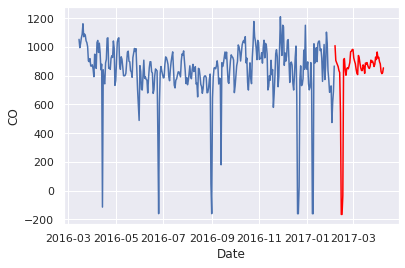

In [262]:
from datetime import datetime,timedelta
result=result_varmax_component(cdata,testdf,['CO','HC','NO2','O3'],parameter,['T','RH'])

In [269]:
def result_sarimax_component(data,target,order,parameter=dict({'CO':dict({}),'NO2':dict({}),'O3':dict({}),'HC':dict({})}),exog=None):
    final=[]
    for feature in order:
         model=SARIMAX(data[feature],**(parameter[feature]),exog=data[exog]).fit()
         y_pred=model.predict(min(target.index),max(target.index),exog=target[exog])  


         print(model.summary())
             
         final=np.concatenate([final,y_pred.to_numpy()])
                      
    return final,model
            

In [271]:
parameter=dict({
    'HC':dict({
        'order':(1, 0, 2),
        'seasonal_order':(0, 0, 1, 7),
        'initialization':'approximate_diffuse',
#         'trend':'ct'
    })
})




HCcomponent,m=result_sarimax_component(cdata,testdf,['HC'],parameter,['T','RH'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.71463D+00    |proj g|=  2.29102D-01

At iterate    5    f=  6.53072D+00    |proj g|=  1.85510D-02

At iterate   10    f=  6.33128D+00    |proj g|=  1.36318D-01


 This problem is unconstrained.



At iterate   15    f=  6.29822D+00    |proj g|=  2.43619D-02

At iterate   20    f=  6.13543D+00    |proj g|=  2.24296D-01

At iterate   25    f=  5.94717D+00    |proj g|=  1.24685D-02

At iterate   30    f=  5.94409D+00    |proj g|=  1.80817D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     43      1     0     0   1.333D-06   5.944D+00
  F =   5.9440863935750450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                      
Dep. Variable:                                  HC   No. Observations:             

In [265]:
res=np.concatenate([result.CO.to_numpy(),HCcomponent,result.NO2.to_numpy(),result.O3.to_numpy()])

In [266]:
exportdf=pd.DataFrame(res,columns=['Value'])


In [267]:
exportdf['id']=exportdf.index


In [268]:
pd.DataFrame({'id':exportdf.index,'Value':res}).to_csv('./result.csv',index=False)



## References

[1] World Health Organisation,2022."Air pollution". Available at https://www.who.int/health-topics/air-pollution#tab=tab_1 . [Last accessed on 27/7/2022]

[2] Ahmed, F. et al.,2019."Impact of household air pollution on human health: source identification and systematic management approach." SN Appl. Sci. 1, 418 .Available at https://doi.org/10.1007/s42452-019-0405-8 [Last accessed on 27/7/2022]

[3] D’Amato, G. et al.,2013." Climate change, air pollution and extreme events leading to increasing prevalence of allergic respiratory diseases." Multidiscip Respir Med 8, 12.Available at https://doi.org/10.1186/2049-6958-8-12 [Last accessed on 27/7/2022]

[4] The United Nations Economic Commission for Europe,2021."International cooperation". Available at https://unece.org/international-cooperation [Last accessed on 27/7/2022]

[5] Hyndman, R. J. & Athanasopoulos, G.,2018. "Forecasting: principles and practice, 2nd edition", Available at  OTexts: Melbourne, Australia. OTexts.com/fpp2. [Last accessed on 27/7/2022]

[6]Chandola, V. et al., 2009. "Anomaly detection: A survey". ACM Computing Surveys. 41 (3): 1–58. Available at https://doi.org/10.1145%2F1541880.1541882 [Last accessed on 27/7/2022]

[7] Mikulski, B.,2019."Using Exponentially Weighted Moving Average for anomaly detection". Available at https://www.mikulskibartosz.name/using-exponentially-weighted-moving-average-for-anomaly-detection/ [Last accessed on 27/7/2022]

[8] RapidMiner,2022."Classic Decomposition". Available at https://docs.rapidminer.com/9.3/studio/operators/modeling/time_series/decomposition/classic_decomposition.html [Last accessed on 27/7/2022]

[9] Granger, C. W. J.,1969. "Investigating Causal Relations by Econometric Models and Cross-spectral Methods". Econometrica. 37 (3): 424–438. Available at https://doi.org/10.2307%2F1912791 . [Last accessed on 30/7/2022]

[10] Barnston, A.,1992. “Correspondence among the Correlation [root mean square error] and Heidke Verification Measures; Refinement of the Heidke Score.” Notes and Correspondence, Climate Analysis Center. Available at https://www.swpc.noaa.gov/sites/default/files/images/u30/Barnston,%20Anthony%20G.,%201992.pdf . [Last accessed on 30/7/2022]

[11] Brownlee, J.,2019."Probabilistic Model Selection with AIC, BIC, and MDL". Available at https://machinelearningmastery.com/probabilistic-model-selection-measures/ . [Last accessed on 30/7/2022]

[12] Burnham, K. P., & Anderson, D. R.,2004. "Multimodel Inference: Understanding AIC and BIC in Model Selection." Sociological Methods & Research, 33(2), 261–304.Available at https://doi.org/10.1177/0049124104268644 .  [Last accessed on 30/7/2022]

[13] Kwiatkowski, D. et al., 1992. "Testing the null hypothesis of stationarity against the alternative of a unit root". Journal of Econometrics. 54 (1–3): 159–178. Available at https://doi.org/10.1016%2F0304-4076%2892%2990104-Y. [Last accessed on 30/7/2022]

